In [1]:
import sys
import numpy as np
import xarray as xr
from scipy.io import loadmat
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
sys.path.append('/Users/jakesteinberg/ECCOv4-py/ECCOv4-py')
import ecco_v4_py as ecco
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# procedure 
# - units of time have to be the same
# - remove time mean, linear trend, and seasonal cycle? 
# steric height     [time x location] 
#    map to regular grid 
# coastal sea level [time x location]

In [3]:
# SSHDYN: boussinesq, greatbatch, IB
# OBPNOPAB: should include a correction for global mean atmospheric forcing 
# test on ETAN and PHIBOT - see if I can get to SSHDYN
# v5 (no pressure forcing): 
# - follow chris's code 
# - ETAN (subtract global mean timeseries)
# - PHIBOT (subtract global mean timeseries)

In [6]:
y_s = 1998
y_e = 2018

In [7]:
## Set top-level file directory for the ECCO NetCDF files
## =================================================================
base_dir = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/'   # # base_dir = '/home/username/'
ECCO_dir = base_dir + '/v5'                                    ## define a high-level directory for ECCO fields
grid_dir= ECCO_dir + '/nctiles_grid/'                          ## Load the model grid
ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCO-GRID.nc')   # ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCOv4r3_grid.nc', k_subset=[0])
## -- Load 2D Monthly data...SSH -- 
data_dir= ECCO_dir + '/nctiles_monthly'
# ecco_daily_vars = ecco.recursive_load_ecco_var_from_years_nc(data_dir, vars_to_load=['SSHDYN','OBPNOPAB'],\
#                                            years_to_load=range(2008,2018)).load()      
ecco_daily_vars = ecco.recursive_load_ecco_var_from_years_nc(data_dir, vars_to_load=['ETAN','PHIBOT','sIceLoad'],\
                                           years_to_load=range(y_s,y_e)).load()      
## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ecco_monthly_ds = xr.merge((ecco_grid , ecco_daily_vars))

loading files of  ETAN
loading files of  PHIBOT
loading files of  sIceLoad


In [9]:
print(ecco_monthly_ds.time[0].data)
print(ecco_monthly_ds.time[-1].data)

1998-01-16T12:00:00.000000000
2017-12-16T12:00:00.000000000


In [10]:
depth = ecco_monthly_ds.Depth.where(ecco_monthly_ds.hFacC.isel(k=0) !=0, np.nan)
ocean_mask = np.ceil(ecco_monthly_ds.hFacC[0])
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)
total_ocean_area = np.sum(ecco_monthly_ds.rA*ocean_mask[0,:])

In [11]:
# if v5 
SSH = ocean_mask*(ecco_monthly_ds.ETAN + ecco_monthly_ds.sIceLoad/1029)
OBP = ocean_mask*(ecco_monthly_ds.PHIBOT/9.81);
# remove glo
SSHA = SSH - (SSH*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area
OBPA = OBP - (OBP*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area
steric_height = SSHA-OBPA
steric_height_anom = steric_height - steric_height.mean(dim='time')
obp_anom = OBPA - OBPA.mean(dim='time')

In [5]:
# global area weighted mean SSH,OBP 
SSHDYN_global_mean_mon = (ecco_monthly_ds.SSHDYN*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area
SSHDYN_global_mean_mon = SSHDYN_global_mean_mon - SSHDYN_global_mean_mon.mean(dim=['time'])
OBP_global_mean_mon = ((ecco_monthly_ds.OBPNOPAB)*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area
OBP_global_mean_mon = OBP_global_mean_mon - OBP_global_mean_mon.mean(dim=['time'])
steric_height_global_mean =  SSHDYN_global_mean_mon - OBP_global_mean_mon

In [6]:
# v4
steric_height = ecco_monthly_ds.SSHDYN - ecco_monthly_ds.OBPNOPAB
steric_height_anom = steric_height - steric_height.mean(dim='time')
obp_anom = ecco_monthly_ds.OBPNOPAB - ecco_monthly_ds.OBPNOPAB.mean(dim='time')

-179.75 179.75
-180.0 180.0
-89.75 89.75
-90.0 90.0


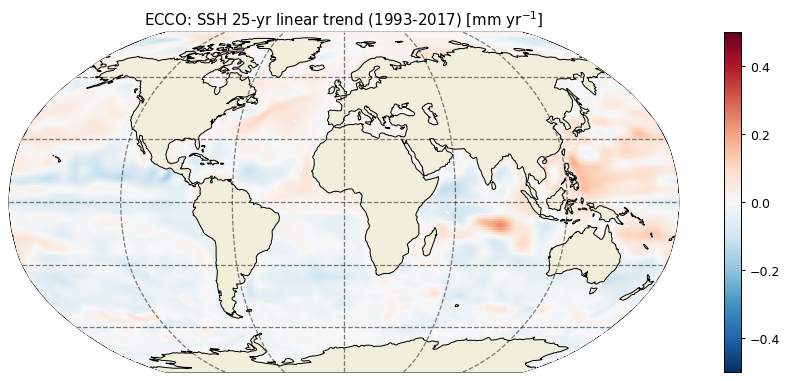

In [14]:
f1 = plt.figure(figsize=(13,5), dpi= 90)
ecco.plot_proj_to_latlon_grid(ecco_monthly_ds.XC, ecco_monthly_ds.YC, steric_height[10] - steric_height.mean(dim='time'), \
                              user_lon_0=0,plot_type='pcolormesh',show_colorbar=True, cmin=-0.5, cmax=0.5, dx=0.5, dy=0.5); # cmin=-0.3, cmax=0.3
plt.title('ECCO: SSH 25-yr linear trend (1993-2017) [mm yr$^{-1}$]');

In [7]:
# OLD, for now just select one tile 
# tile_num = 10
# sha10 = steric_height_anom.sel(tile=tile_num)
# lons = np.copy(ecco_monthly_ds.XC.sel(tile=tile_num))
# lats = ecco_monthly_ds.YC.isel(tile=tile_num)

In [12]:
# regrid from ecco tiles 
new_grid_delta_lat = 0.5
new_grid_delta_lon = 0.5
lat_s = 5; lat_n = 65;
lon_w = -100; lon_e = 0;
new_grid_min_lat = lat_s+new_grid_delta_lat/2
new_grid_max_lat = lat_n-new_grid_delta_lat/2
new_grid_min_lon = lon_w+new_grid_delta_lon/2
new_grid_max_lon = lon_e-new_grid_delta_lon/2
new_grid_lat = np.arange(lat_s + new_grid_delta_lat/2, lat_n, new_grid_delta_lat) # -new_grid_delta_lat/2
new_grid_lon = np.arange(lon_w + new_grid_delta_lon/2, lon_e, new_grid_delta_lon) # -new_grid_delta_lon/2

In [13]:
sha = np.nan*np.ones((np.shape(steric_height_anom)[3],len(new_grid_lat),len(new_grid_lon)))
obpa = np.nan*np.ones((np.shape(steric_height_anom)[3],len(new_grid_lat),len(new_grid_lon)))
for i in range(np.shape(steric_height_anom)[3]):
    a = ecco.resample_to_latlon(ecco_monthly_ds.XC,ecco_monthly_ds.YC,steric_height_anom[:,:,:,i], \
                                lat_s, lat_n, new_grid_delta_lat, lon_w, lon_e, new_grid_delta_lon, \
                                fill_value=np.NaN,mapping_method='nearest_neighbor',radius_of_influence=120000);
    b = ecco.resample_to_latlon(ecco_monthly_ds.XC,ecco_monthly_ds.YC,obp_anom[:,:,:,i], \
                                lat_s, lat_n, new_grid_delta_lat, lon_w, lon_e, new_grid_delta_lon, \
                                fill_value=np.NaN,mapping_method='nearest_neighbor',radius_of_influence=120000); # new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat, new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon, \
    sha[i,:,:] = a[4];
    obpa[i,:,:] = b[4];
d = ecco.resample_to_latlon(ecco_monthly_ds.XC,ecco_monthly_ds.YC,depth, \
                            lat_s, lat_n, new_grid_delta_lat, lon_w, lon_e, new_grid_delta_lon, \
                            fill_value=np.NaN,mapping_method='nearest_neighbor',radius_of_influence=120000);
dep = d[4];

-99.75 -0.25
-100.0 0.0
5.25 64.75
5.0 65.0
-99.75 -0.25
-100.0 0.0
5.25 64.75
5.0 65.0
-99.75 -0.25
-100.0 0.0
5.25 64.75
5.0 65.0
-99.75 -0.25
-100.0 0.0
5.25 64.75
5.0 65.0
-99.75 -0.25
-100.0 0.0
5.25 64.75
5.0 65.0
-99.75 -0.25
-100.0 0.0
5.25 64.75
5.0 65.0
-99.75 -0.25
-100.0 0.0
5.25 64.75
5.0 65.0
-99.75 -0.25
-100.0 0.0
5.25 64.75
5.0 65.0
-99.75 -0.25
-100.0 0.0
5.25 64.75
5.0 65.0
-99.75 -0.25
-100.0 0.0
5.25 64.75
5.0 65.0
-99.75 -0.25
-100.0 0.0
5.25 64.75
5.0 65.0
-99.75 -0.25
-100.0 0.0
5.25 64.75
5.0 65.0
-99.75 -0.25
-100.0 0.0
5.25 64.75
5.0 65.0
-99.75 -0.25
-100.0 0.0
5.25 64.75
5.0 65.0
-99.75 -0.25
-100.0 0.0
5.25 64.75
5.0 65.0
-99.75 -0.25
-100.0 0.0
5.25 64.75
5.0 65.0
-99.75 -0.25
-100.0 0.0
5.25 64.75
5.0 65.0
-99.75 -0.25
-100.0 0.0
5.25 64.75
5.0 65.0
-99.75 -0.25
-100.0 0.0
5.25 64.75
5.0 65.0
-99.75 -0.25
-100.0 0.0
5.25 64.75
5.0 65.0
-99.75 -0.25
-100.0 0.0
5.25 64.75
5.0 65.0
-99.75 -0.25
-100.0 0.0
5.25 64.75
5.0 65.0
-99.75 -0.25
-100.0 0.0
5.25 64.

In [14]:
# create dataset
filename = ('/Users/jakesteinberg/Documents/NASA_OSTST/analysis/eccov5_sha_obpa_halfdeg_' + str(y_s) + '_' + str(y_e-1) + '.nc')
ds = xr.Dataset(
    data_vars=dict(
        sha=(["time","j","i"], sha),
        obpa=(["time","j","i"], obpa),
        dep=(["j","i"], dep),
    ),
    coords=dict(
        j=(["j"], new_grid_lat),
        i=(["i"], new_grid_lon),
        time=(["time"], steric_height_anom.time.data),
    ),
)

In [37]:
ecco_sha = ds.sha
ecco_obpa = ds.obpa
ecco_dep = ds.dep
ecco_time = ds.time

In [15]:
# -- save file -- 
ds.to_netcdf(path=filename)

In [27]:
# -- load file -- 
x = xr.open_dataset('/Users/jakesteinberg/Documents/NASA_OSTST/analysis/eccov5_sha_obpa_halfdeg_1996_2005.nc')
ecco_sha = x['sha']
ecco_obpa = x['obpa']
ecco_dep = x['dep']
new_grid_lon = x['i']
new_grid_lat = x['j']
lon_w = new_grid_lon[0] - (new_grid_lon[1]-new_grid_lon[0])/2
lon_e = new_grid_lon[-1] + (new_grid_lon[1]-new_grid_lon[0])/2
lat_s = new_grid_lat[0] - (new_grid_lat[1]-new_grid_lat[0])/2
lat_n = new_grid_lat[-1] + (new_grid_lat[1]-new_grid_lat[0])/2
ecco_time = x['time']

In [17]:
# TG: load initially processed tide gauge records in GOM and along U.S. east coast 
tg_data = loadmat('/Users/jakesteinberg/Documents/NASA_OSTST/tide_gauge/natl_gauges_1970_2021.mat')
t_rec = []; 
for i in range(len(tg_data['t_grid'][0,:])):
    t_i = datetime.fromordinal(tg_data['t_grid'][0,i] - 366)
    t_rec.append(t_i)
data_da = xr.DataArray(data=tg_data['height_grid']/1000, dims=["location","time"],
                        coords=dict(
                            location=(["location"], tg_data['ID'][0,:]), time=(["time"], t_rec),
                            lon=(['location'], tg_data['lon'][0,:]), lat=(['location'], tg_data['lat'][0,:]),
                        ),        
                       )
id_tags_east_coast = ['PORTLAND','BOSTON','WOODS HOLE (OCEAN. INST.)','MONTAUK','SANDY HOOK',\
                     'ATLANTIC CITY','CAPE MAY','KIPTOPEKE BEACH','SEWELLS POINT, HAMPTON ROADS',\
                     'OREGON INLET MARINA, NORTH CAROLINA','BEAUFORT','SPRINGMAID PIER','CHARLESTON I',\
                     'FORT PULASKI','FERNANDINA BEACH','LAKE WORTH PIER'];
id_tags_GOM = ['KEY WEST','NAPLES','FORT MYERS','ST. PETERSBURG','CLEARWATER BEACH',\
               'CEDAR KEY II', 'APALACHICOLA','PANAMA CITY, ST.ANDREWS BAY, FL','PENSACOLA', \
               'DAUPHIN ISLAND','MOBILE STATE DOCKS, ALABAMA','BAY WAVELAND YACHT CLUB',\
               'SHELL BEACH, LOUISIANA','GRAND ISLE','SABINE PASS','GALVESTON II, PIER 21, TX',\
               'FREEPORT','CORPUS CHRISTI, GULF MEXICO, TX','PORT ISABEL']
id_tags = id_tags_east_coast + id_tags_GOM

In [18]:
# -- TG: Vertical Land Motion -- from multiple stations interpolated to tide gauge sites (better data)
file_int = open("/Users/jakesteinberg/Documents/NASA_OSTST/tide_gauge/vlm_at_psmsl_gauges.txt")
data_int = file_int.readlines(); file_int.close()
name = []; name_row = []
for i in range(len(data_int)):
    if data_int[i][0] == '>':
        for j in range(len(data_int[i])):
            if data_int[i][j] == '\n':
                ee = j
                break
        name.append(data_int[i][9:ee])
        name_row.append(i)
        
# -- processing to get one number per tide gauge site 
vlm_rate = np.nan*np.ones(len(id_tags))
vlm_un = np.nan*np.ones(len(id_tags))
for i in range(len(id_tags)):
    ii = name.index(id_tags[i])
    this_row = data_int[name_row[ii]+1].split()
    vlm_rate[i] = -1*np.float64(this_row[3])/1000  # convert from mm/yr
    vlm_un[i] = np.float64(this_row[4])/1000 # uncertainty 

In [19]:
# -- TG: subset to remove mean from all years 
t_s = '1998-01-01'; t_e = '2017-12-31'
tg = data_da.sel(time=slice(t_s, t_e))
tg_a = tg - data_da.sel(time=slice(t_s, t_e)).mean(dim='time') # relative to 1993-2021 mean? 

In [20]:
# -- TG: seasonal cycles and trend 
ids = data_da.location.data
tg_time = tg.time.data
# - array of datetimes 
time_ord = np.nan*np.ones(len(tg_time))
for i in range(len(tg_time)):
    ts = (np.datetime64(str(tg_time[i])[0:10]) - np.datetime64('0000-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    time_ord[i] = ts/(60*60*24)
    
def seasonal_cycle(x,a,b,c,d,f):
    return a*np.sin((2*np.pi/365)*x+b) + c*np.sin((2*np.pi/(365/2))*x+d) + f 
def seasonal_plus_trend(x,a,b,c,d,e,f):
    return a*np.sin((2*np.pi/365)*x+b) + c*np.sin((2*np.pi/(365/2))*x+d) + e*x + f 

In [21]:
# -- TG: place tide gauge on ecco monthly grid 
tide_gauge_anom_month = tg_a.interp(time=ecco_sha.time).transpose()
# -- ECCO: 
ecco_zeta_rho_month = ecco_sha
ecco_obpa_month = ecco_obpa

In [22]:
# replace land with nans
ecco_zeta_rho_month = ecco_zeta_rho_month.where((ecco_zeta_rho_month > 0) | (ecco_zeta_rho_month < 0), other=np.nan)
ecco_obpa_month = ecco_obpa_month.where((ecco_zeta_rho_month > 0) | (ecco_zeta_rho_month < 0), other=np.nan)

In [23]:
# remove section(s) of the pacific 
polo = np.where(new_grid_lon < -75)[0]; pola = np.where(new_grid_lat < 8.5)[0]
ecco_zeta_rho_month[:,np.arange(pola[0],pola[-1]),np.arange(polo[0],polo[-1])] = np.nan
ecco_obpa_month[:,np.arange(pola[0],pola[-1]),np.arange(polo[0],polo[-1])] = np.nan

In [24]:
polo = np.where(new_grid_lon < -84)[0]; pola = np.where(new_grid_lat < 13)[0]
ecco_zeta_rho_month[:,np.arange(pola[0],pola[-1]),np.arange(polo[0],polo[-1])] = np.nan
ecco_obpa_month[:,np.arange(pola[0],pola[-1]),np.arange(polo[0],polo[-1])] = np.nan

In [25]:
polo = np.where(new_grid_lon < -87)[0]; pola = np.where(new_grid_lat < 17)[0]
ecco_zeta_rho_month[:,np.arange(pola[0],pola[-1]),np.arange(polo[0],polo[-1])] = np.nan
ecco_obpa_month[:,np.arange(pola[0],pola[-1]),np.arange(polo[0],polo[-1])] = np.nan

In [26]:
# remove hudson bay
polo = np.where(new_grid_lon < -75)[0]; pola = np.where(new_grid_lat > 50)[0]
ecco_zeta_rho_month[:,np.arange(pola[0],pola[-1]),np.arange(polo[0],polo[-1])] = np.nan
ecco_obpa_month[:,np.arange(pola[0],pola[-1]),np.arange(polo[0],polo[-1])] = np.nan

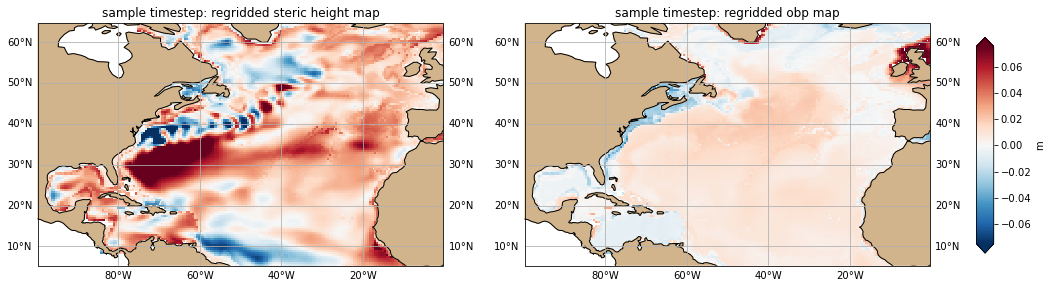

In [27]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
cc =ax1.pcolor(new_grid_lon,new_grid_lat,ecco_zeta_rho_month[11,:,:],vmin=-0.075,vmax=0.075,cmap='RdBu_r', transform=ccrs.PlateCarree()); ax1.set_title('sample timestep: regridded steric height map')
ax1.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax1.coastlines()
gl = ax1.gridlines(draw_labels=True); gl.xlabels_top = False; ax1.set_facecolor('w');
ax2.pcolor(new_grid_lon,new_grid_lat,ecco_obpa_month[11,:,:],vmin=-0.1,vmax=0.1,cmap='RdBu_r', transform=ccrs.PlateCarree()); ax2.set_title('sample timestep: regridded obp map')
ax2.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax2.coastlines()
gl = ax2.gridlines(draw_labels=True); gl.xlabels_top = False; ax2.set_facecolor('w');
cbpos = [0.94, 0.2, 0.015, 0.6]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='vertical', extend='both', label='m');
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2023_03_23/sample_fields.jpg', dpi=400)

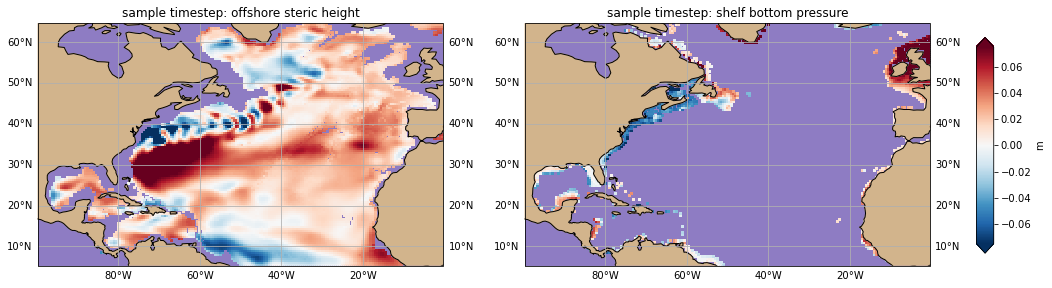

In [66]:
# -- filter by depth -- 
ecco_obpa_shelf_month = ecco_obpa_month.where((ecco_dep > 0) & (ecco_dep < 200), other=np.nan)
ecco_zeta_rho_deep_month = ecco_zeta_rho_month.where((ecco_dep > 1500), other=np.nan)

f, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
cc = ax1.pcolor(new_grid_lon,new_grid_lat,ecco_zeta_rho_deep_month[11,:,:],vmin=-0.075,vmax=0.075,cmap='RdBu_r',transform=ccrs.PlateCarree()); 
ax1.set_title('sample timestep: offshore steric height')
ax1.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax1.coastlines()
gl = ax1.gridlines(draw_labels=True); gl.xlabels_top = False; ax1.set_facecolor('w');
ax1.set_facecolor('#8e7cc3')
ax2.pcolor(new_grid_lon,new_grid_lat,ecco_obpa_shelf_month[11,:,:],vmin=-0.05,vmax=0.05,cmap='RdBu_r',transform=ccrs.PlateCarree()); 
ax2.set_title('sample timestep: shelf bottom pressure')
ax2.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax2.coastlines()
gl = ax2.gridlines(draw_labels=True); gl.xlabels_top = False; ax2.set_facecolor('w');
cbpos = [0.94, 0.2, 0.015, 0.6]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='vertical', extend='both', label='m');
ax2.set_facecolor('#8e7cc3')
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2023_04_mca/sample_fields_cut.jpg', dpi=400)

In [29]:
# collapse two horizontal dimensions to one 
ecco_zeta_rho_month_full = ecco_zeta_rho_month.stack(k=("j", "i")) # .unstack("z")
ecco_obpa_month_full = ecco_obpa_month.stack(k=("j", "i")) # .unstack("z")
# shelf vs. offshore 
ecco_zeta_rho_month_0 = ecco_zeta_rho_deep_month.stack(k=("j", "i")) # .unstack("z")
ecco_obpa_shelf_month_0 = ecco_obpa_shelf_month.stack(k=("j", "i")) # .unstack("z")

In [30]:
# remove nan (land) timeseries 
# ----------
ecco_zeta_rho_month_full1 = ecco_zeta_rho_month_full[:,~np.isnan(ecco_zeta_rho_month_full[0,:].data)]
ecco_obpa_month_full1 = ecco_obpa_month_full[:,~np.isnan(ecco_obpa_month_full[0,:].data)]
ecco_zeta_rho_month_full_w = ecco_zeta_rho_month_full1.interpolate_na(dim='time')
ecco_obpa_month_full_w = ecco_obpa_month_full1.interpolate_na(dim='time')
# ----------
ecco_zeta_rho_month_1 = ecco_zeta_rho_month_0[:,~np.isnan(ecco_zeta_rho_month_0[0,:].data)]
ecco_obpa_shelf_month_1 = ecco_obpa_shelf_month_0[:,~np.isnan(ecco_obpa_shelf_month_0[0,:].data)]
# interpolate remaining nans (some locations have nans at times)
ecco_zeta_rho_month_w = ecco_zeta_rho_month_1.interpolate_na(dim='time')
ecco_obpa_shelf_month_w = ecco_obpa_shelf_month_1.interpolate_na(dim='time')

In [31]:
# band-aid for now, remaining nans 
stragglers = np.where(np.isnan(ecco_zeta_rho_month_full_w))
stragglers_obpa = np.where(np.isnan(ecco_obpa_month_full_w)) # NONE HERE
for i in range(len(stragglers[0])):
    ecco_zeta_rho_month_full_w[stragglers[0][i],stragglers[1][i]] = ecco_zeta_rho_month_full_w[stragglers[0][i],stragglers[1][i]-1] - 0.001
for i in range(len(stragglers_obpa[0])):
    ecco_obpa_month_full_w[stragglers_obpa[0][i],stragglers_obpa[1][i]] = ecco_obpa_month_full_w[stragglers_obpa[0][i],stragglers_obpa[1][i]-1] - 0.001

In [32]:
# band-aid for now, remaining nans 
stragglers = np.where(np.isnan(ecco_zeta_rho_month_w))
stragglers_obpa = np.where(np.isnan(ecco_obpa_shelf_month_w)) # NONE HERE
for i in range(len(stragglers[0])):
    ecco_zeta_rho_month_w[stragglers[0][i],stragglers[1][i]] = ecco_zeta_rho_month_w[stragglers[0][i],stragglers[1][i]-1] - 0.001

In [33]:
print(np.sum(np.isnan(ecco_zeta_rho_month_w.data)))
print(np.sum(np.isnan(ecco_obpa_shelf_month_w.data)))

0
0


In [34]:
# Tide Gauge: interpolate nans and remove bad timeseries 
tg_g = []
for i in range(np.shape(tide_gauge_anom_month)[1]):
    tide_gauge_anom_month[:,i] = tide_gauge_anom_month[:,i].interpolate_na(dim='time')
    if np.sum(np.isnan(tide_gauge_anom_month[:,i].data)) < 1:
        tg_g.append(i)
    # print(np.sum(np.isnan(tide_gauge_anom_month[:,i].data)))
tide_gauge_anom_month_w = tide_gauge_anom_month[:,tg_g]

In [35]:
# [time by profile]
print(np.shape(tide_gauge_anom_month_w))
print(np.shape(ecco_zeta_rho_month_w))
print(np.shape(ecco_obpa_shelf_month_w))
print(np.shape(ecco_zeta_rho_month_w)[1]*np.shape(ecco_obpa_shelf_month_w)[1])

(240, 27)
(240, 12434)
(240, 1399)
17395166


In [26]:
tide_gauge_anom_month_w

<xarray.DataArray (time: 120, location: 0)>
array([], shape=(120, 0), dtype=float64)
Coordinates:
  * location  (location) uint16 
    lon       (location) float64 
    lat       (location) float64 
  * time      (time) datetime64[ns] 1996-01-16T12:00:00 ... 2005-12-16T12:00:00

In [38]:
# time array [datetimes] 
time_ord = np.nan*np.ones(np.shape(ecco_time)[0])
for i in range(np.shape(ecco_time)[0]):
    ts = (np.datetime64(str(ecco_time[i].time.data)[0:10]) - np.datetime64('0000-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    time_ord[i] = ts/(60*60*24)

In [24]:
# remove seasonal cycle 
# TIDE GAUGE 
tide_gauge_anom_month_w_wosea = tide_gauge_anom_month_w.copy()
for i in range(np.shape(tide_gauge_anom_month_w)[1]):
    # -- fit seasonal cycle over entire time series 
    fit = curve_fit(seasonal_cycle, time_ord - time_ord[0], tide_gauge_anom_month_w[:,i])
    model = seasonal_cycle((time_ord - time_ord[0]),*fit[0])
    tide_gauge_anom_month_w_wosea[:,i] = tide_gauge_anom_month_w[:,i] - model

In [39]:
# remove seasonal cycle 
# STERIC HEIGHT
ecco_zeta_rho_month_w_wosea = ecco_zeta_rho_month_w.copy()
for i in range(np.shape(ecco_zeta_rho_month_w)[1]):
    # -- fit seasonal cycle over entire time series 
    fit = curve_fit(seasonal_cycle, time_ord - time_ord[0], ecco_zeta_rho_month_w[:,i])
    model = seasonal_cycle((time_ord - time_ord[0]),*fit[0])
    ecco_zeta_rho_month_w_wosea[:,i] = ecco_zeta_rho_month_w[:,i] - model
    
# remove seasonal cycle 
# OBPA SHELF
ecco_obpa_shelf_month_w_wosea = ecco_obpa_shelf_month_w.copy()
for i in range(np.shape(ecco_obpa_shelf_month_w)[1]):
    # -- fit seasonal cycle over entire time series 
    fit = curve_fit(seasonal_cycle, time_ord - time_ord[0], ecco_obpa_shelf_month_w[:,i])
    model = seasonal_cycle((time_ord - time_ord[0]),*fit[0])
    ecco_obpa_shelf_month_w_wosea[:,i] = ecco_obpa_shelf_month_w[:,i] - model

NameError: name 'tide_gauge_anom_month_w_wosea' is not defined

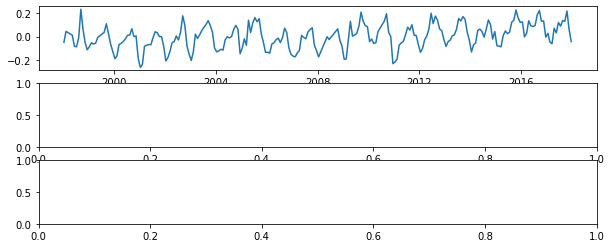

In [40]:
# compare timeseries w/wo seasonal cycle 
indi = 20
f, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,4))
ax1.plot(tide_gauge_anom_month_w.time,tide_gauge_anom_month_w[:,indi])
ax1.plot(tide_gauge_anom_month_w.time,tide_gauge_anom_month_w_wosea[:,indi])
ax1.grid(); ax1.set_title('tide gauge');
ax2.plot(tide_gauge_anom_month_w.time,ecco_zeta_rho_month_w[:,indi])
ax2.plot(tide_gauge_anom_month_w.time,ecco_zeta_rho_month_w_wosea[:,indi])
ax2.grid(); ax2.set_title('steric');
ax3.plot(tide_gauge_anom_month_w.time,ecco_obpa_shelf_month_w[:,indi])
ax3.plot(tide_gauge_anom_month_w.time,ecco_obpa_shelf_month_w_wosea[:,indi])
ax3.grid(); ax3.set_title('shelf obpa');

In [41]:
# -- COVARIANCE MATRIX -- 
# covm = np.matrix(ecco_zeta_rho_month_w).transpose()*np.matrix(tide_gauge_anom_month_w)

# -- scale by standard deviation -- 
# covm = np.matrix(ecco_zeta_rho_month_w/np.nanstd(ecco_zeta_rho_month_w,axis=0)).transpose()*\
#     np.matrix(tide_gauge_anom_month_w/np.nanstd(tide_gauge_anom_month_w,axis=0))

# -- w/o seasonal cycle -- 
# covm = np.matrix(ecco_zeta_rho_month_w_wosea/np.nanstd(ecco_zeta_rho_month_w_wosea,axis=0)).transpose()*\
#     np.matrix(tide_gauge_anom_month_w_wosea/np.nanstd(tide_gauge_anom_month_w_wosea,axis=0))

# steric height & shelf bottom pressure 
# -- w/o seasonal cycle -- 
covm = np.matrix(ecco_zeta_rho_month_w_wosea/np.nanstd(ecco_zeta_rho_month_w_wosea,axis=0)).transpose()*\
    np.matrix(ecco_obpa_shelf_month_w_wosea/np.nanstd(ecco_obpa_shelf_month_w_wosea,axis=0))

In [60]:
np.shape(ecco_zeta_rho_month_w_wosea)

(240, 12434)

In [42]:
U,S,V = np.linalg.svd(covm)

In [50]:
print(S[0:4]**2/np.sum(S**2))

[0.56699545 0.24300878 0.082177   0.03875237]


In [44]:
# -- EXPANSION COEFFICIENTS -- 
s1_ec = np.matrix(ecco_zeta_rho_month_w_wosea)*np.matrix(U)
s2_ec = np.matrix(ecco_obpa_shelf_month_w_wosea)*np.matrix(V)

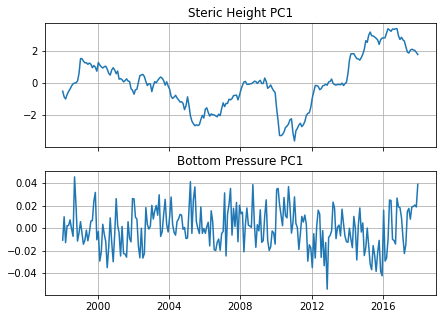

In [62]:
f, (ax1,ax2) = plt.subplots(2,1,figsize=(7,5))
ax1.plot(ecco_time,s1_ec[:,0])
ax1.set_title('Steric Height PC1'); ax1.grid(); ax1.set_xticklabels('')
ax2.plot(ecco_time,s2_ec[:,0])
ax2.set_title('Bottom Pressure PC1'); ax2.grid()
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2023_04_mca/mca_pc1.jpg', dpi=400)

In [46]:
# S1 (variable 1 = steric height)
re_map1 = np.nan*np.ones(np.shape(ecco_zeta_rho_month[0,:,:]))
re_corr1 = np.nan*np.ones(np.shape(ecco_zeta_rho_month[0,:,:]))
re_map2 = np.nan*np.ones(np.shape(ecco_zeta_rho_month[0,:,:]))
re_corr2 = np.nan*np.ones(np.shape(ecco_zeta_rho_month[0,:,:]))
for i in range(len(U[:,0])): # loop over each location 
    kij = ecco_zeta_rho_month_w.k.data[i]
    loni = np.where(new_grid_lon == kij[1])[0]
    lati = np.where(new_grid_lat == kij[0])[0]
    # -- homogeneous correlation map -- 
    # -- (expansion coefficient of 1st mode of s1 w/ s1 values) -- 
    cor1 = np.corrcoef(np.squeeze(s1_ec[:,0]),ecco_zeta_rho_month_w_wosea[:,i])
    re_map1[lati,loni] = U[i,0]
    re_corr1[lati,loni] = cor1[0,1]
    re_map2[lati,loni] = U[i,1] # mode 2 of s1
    
    # -- heterogeneous correlation map -- 
    # -- (expansion coefficient of 1st mode of s2 w/ s1 values) -- 
    cor2 = np.corrcoef(np.squeeze(s2_ec[:,0]),ecco_zeta_rho_month_w_wosea[:,i])
    re_corr2[lati,loni] = cor2[0,1]

# if s2 = tide gauge 
# re_corr3 = np.nan*np.ones(np.shape(tide_gauge_anom_month_w[0]))
# re_corr4 = np.nan*np.ones(np.shape(tide_gauge_anom_month_w[0]))
# for i in range(len(V[:,0])):
#     # hetereogeneous correlation map 
#     # (expansion coefficient of 1st mode of steric height w/ tide gauge values)
#     cor3 = np.corrcoef(np.squeeze(s1_ec[:,0]),tide_gauge_anom_month_w_wosea[:,i])
#     re_corr3[i] = cor3[0,1]
#     # homogeneous correlation map 
#     # (expansion coefficient of 1st mode of tide gauge w/ tide gauge values)
#     cor4 = np.corrcoef(np.squeeze(s2_ec[:,0]),tide_gauge_anom_month_w_wosea[:,i])
#     re_corr4[i] = cor4[0,1]
    
re_map3 = np.nan*np.ones(np.shape(ecco_obpa_shelf_month[0,:,:]))
re_corr3 = np.nan*np.ones(np.shape(ecco_obpa_shelf_month[0,:,:]))
re_map4 = np.nan*np.ones(np.shape(ecco_obpa_shelf_month[0,:,:]))
re_corr4 = np.nan*np.ones(np.shape(ecco_obpa_shelf_month[0,:,:]))
for i in range(len(V[:,0])):
    kij = ecco_obpa_shelf_month_w.k.data[i]
    loni = np.where(new_grid_lon == kij[1])[0]
    lati = np.where(new_grid_lat == kij[0])[0]
    # -- homogeneous correlation map -- 
    # -- (expansion coefficient of 1st mode of s2 w/ s2 values) -- 
    cor3 = np.corrcoef(np.squeeze(s2_ec[:,0]),ecco_obpa_shelf_month_w_wosea[:,i])
    re_map3[lati,loni] = V[0,i] # V[i,0]
    re_corr3[lati,loni] = cor3[0,1]
    re_map4[lati,loni] = V[i,1]
    
    # --  heterogeneous correlation map -- 
    # -- (expansion coefficient of 1st mode of s1 w/ s2 values) -- 
    cor4 = np.corrcoef(np.squeeze(s1_ec[:,0]),ecco_obpa_shelf_month_w_wosea[:,i])
    re_corr4[lati,loni] = cor4[0,1]

Maximum Covariance Analysis 

datasets -
S, P 

1. form the covariance matrix C = S$^t$P
2. option to scale by dividing each time series by its standard deviation 
3. SVD --> C = ULV$^t$
4. U, V are singular vectors for S and P, each pair (first columns of U and V) are modes of co-variability between fields S and P
5. expansion coefficients (describes how each mode varies in time) 
    5a. A = SU
    5b. B = PV
6. L are singular vectors describing fraction of total squared covariance in C

Plotting
1. Correlation maps: 
    1a. homogeneous: correlations between expansion coefficient of kth mode of a field and the values of that same field 
    1b. hetereogeneous: correlations between expansion coefficient of kth mode of a field and the values of the other field 


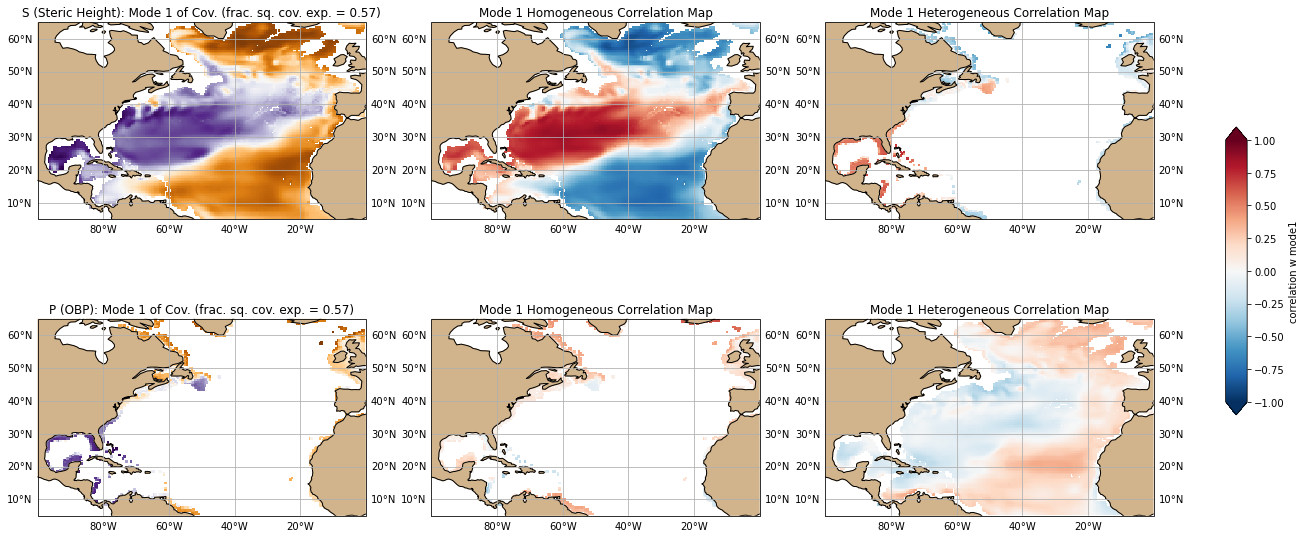

In [67]:
xbs = [lon_w,lon_e]; ybs = [lat_s,lat_n]
# xbs = [-100,-40]; ybs = [10,50]
crrcmp = plt.get_cmap('RdBu_r'); tgcmp = plt.get_cmap('PuOr'); 
f, ax = plt.subplots(2,3,figsize=(20,10), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
###########################################
# --- mode1 pattern ---
ax[0,0].pcolor(new_grid_lon,new_grid_lat,re_map1,transform=ccrs.PlateCarree(), \
               vmin=np.nanmin(re_map1), vmax=np.nanmax(re_map1), cmap=tgcmp)
ax[0,0].set_title('S (Steric Height): Mode 1 of Cov. (frac. sq. cov. exp. = ' + str(np.round(S[0]**2/np.sum(S**2),2)) + ')') # S1
ax[0,0].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax[0,0].coastlines()
gl = ax[0,0].gridlines(draw_labels=True); gl.xlabels_top = False; ax[0,0].set_facecolor('w');
ax[0,0].set_xlim(xbs); ax[0,0].set_ylim(ybs); 
# --- homogeneous correlation map ---
cc = ax[0,1].pcolor(new_grid_lon,new_grid_lat,re_corr1,vmin=-1,vmax=1,cmap=crrcmp,transform=ccrs.PlateCarree())
ax[0,1].set_title('Mode 1 Homogeneous Correlation Map')    
ax[0,1].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax[0,1].coastlines()
gl = ax[0,1].gridlines(draw_labels=True); gl.xlabels_top = False; ax[0,1].set_facecolor('w');
ax[0,1].set_xlim(xbs); ax[0,1].set_ylim(ybs); # ax[0,1].set_facecolor('#66C066')
# --- heterogeneous correlation map 
cc = ax[0,2].pcolor(new_grid_lon,new_grid_lat,re_corr4,vmin=-1,vmax=1,cmap=crrcmp,transform=ccrs.PlateCarree())
ax[0,2].set_title('Mode 1 Heterogeneous Correlation Map')    
ax[0,2].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax[0,2].coastlines()
gl = ax[0,2].gridlines(draw_labels=True); gl.xlabels_top = False; ax[0,2].set_facecolor('w');
ax[0,2].set_xlim(xbs); ax[0,2].set_ylim(ybs); # ax[0,2].set_facecolor('#66C066')
###########################################
# xbs = [-140,10]; ybs = [-10,60]
ax[1,0].pcolor(new_grid_lon,new_grid_lat,re_map3,transform=ccrs.PlateCarree(), \
               vmin=np.nanmin(re_map3), vmax=np.nanmax(re_map3), cmap=tgcmp)
ax[1,0].set_title('P (OBP): Mode 1 of Cov. (frac. sq. cov. exp. = ' + str(np.round(S[0]**2/np.sum(S**2),2)) + ')') # S2
ax[1,0].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax[1,0].coastlines()
gl = ax[1,0].gridlines(draw_labels=True); gl.xlabels_top = False; ax[1,0].set_facecolor('w');
ax[1,0].set_xlim(xbs); ax[1,0].set_ylim(ybs);
# --- homogeneous correlation map ---
cc = ax[1,1].pcolor(new_grid_lon,new_grid_lat,re_corr3,vmin=-1,vmax=1,cmap=crrcmp,transform=ccrs.PlateCarree())
ax[1,1].set_title('Mode 1 Homogeneous Correlation Map')    
ax[1,1].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax[1,1].coastlines()
gl = ax[1,1].gridlines(draw_labels=True); gl.xlabels_top = False; ax[1,1].set_facecolor('w');
ax[1,1].set_xlim(xbs); ax[1,1].set_ylim(ybs);
# --- heterogeneous correlation map 
cc = ax[1,2].pcolor(new_grid_lon,new_grid_lat,re_corr2,vmin=-1,vmax=1,cmap=crrcmp,transform=ccrs.PlateCarree())
ax[1,2].set_title('Mode 1 Heterogeneous Correlation Map')    
ax[1,2].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax[1,2].coastlines()
gl = ax[1,2].gridlines(draw_labels=True); gl.xlabels_top = False; ax[1,2].set_facecolor('w');
ax[1,2].set_xlim(xbs); ax[1,2].set_ylim(ybs);

cbpos = [0.95, 0.3, 0.015, 0.4]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='vertical', extend='both', label='correlation w mode1');
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2023_04_mca/corr_coeffs.jpg', dpi=400)

In [30]:
# remove seasonal cycle 
# STERIC HEIGHT
ecco_zeta_rho_month_full_w_wosea = ecco_zeta_rho_month_full_w.copy()
for i in range(np.shape(ecco_zeta_rho_month_full_w)[1]):
    # -- fit seasonal cycle over entire time series 
    fit = curve_fit(seasonal_cycle, time_ord - time_ord[0], ecco_zeta_rho_month_full_w[:,i])
    model = seasonal_cycle((time_ord - time_ord[0]),*fit[0])
    ecco_zeta_rho_month_full_w_wosea[:,i] = ecco_zeta_rho_month_full_w[:,i] - model
    
# remove seasonal cycle 
# OBPA SHELF
ecco_obpa_month_full_w_wosea = ecco_obpa_month_full_w.copy()
for i in range(np.shape(ecco_obpa_month_full_w)[1]):
    # -- fit seasonal cycle over entire time series 
    fit = curve_fit(seasonal_cycle, time_ord - time_ord[0], ecco_obpa_month_full_w[:,i])
    model = seasonal_cycle((time_ord - time_ord[0]),*fit[0])
    ecco_obpa_month_full_w_wosea[:,i] = ecco_obpa_month_full_w[:,i] - model

In [31]:
np.shape(ecco_zeta_rho_month_full_w_wosea)

(120, 15408)

In [32]:
covm_sv = np.matrix(ecco_zeta_rho_month_full_w_wosea/np.nanstd(ecco_zeta_rho_month_full_w_wosea,axis=0)).transpose()*\
    np.matrix(ecco_zeta_rho_month_full_w_wosea/np.nanstd(ecco_zeta_rho_month_full_w_wosea,axis=0))
U_sv,S_sv,V_sv = np.linalg.svd(covm_sv)

In [33]:
print(S_sv[0]**2/np.sum(S_sv**2))

0.47099506903523697


In [34]:
sha_eof1 = np.nan*np.ones(np.shape(ecco_zeta_rho_month[0,:,:]))
for i in range(len(U_sv[:,0])): # loop over each location 
    kij = ecco_zeta_rho_month_full_w_wosea.k.data[i]
    loni = np.where(new_grid_lon == kij[1])[0]
    lati = np.where(new_grid_lat == kij[0])[0]
    sha_eof1[lati,loni] = U_sv[i,0]

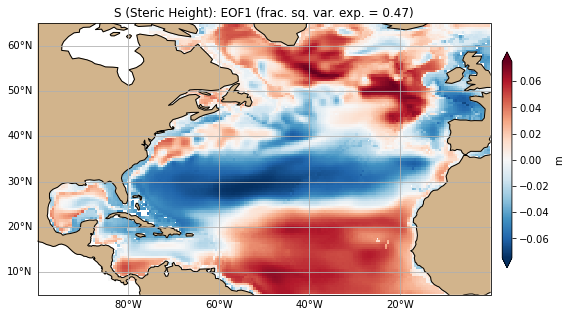

In [35]:
xbs = [lon_w,lon_e]; ybs = [lat_s,lat_n]; crrcmp = plt.get_cmap('RdBu_r');
f, ax = plt.subplots(1,1,figsize=(9,5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
ax.pcolor(new_grid_lon,new_grid_lat,sha_eof1,transform=ccrs.PlateCarree(), vmin=np.nanmin(sha_eof1), vmax=np.nanmax(sha_eof1), cmap=crrcmp)
ax.set_title('S (Steric Height): EOF1 (frac. sq. var. exp. = ' + str(np.round(S_sv[0]**2/np.sum(S_sv**2),2)) + ')') # S1
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False; ax.set_facecolor('w');
ax.set_xlim(xbs); ax.set_ylim(ybs); 
cbpos = [0.88, 0.2, 0.015, 0.6]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='vertical', extend='both', label='m');
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2023_03_23/sha_eof1_1996_2005_dcmap.jpg', dpi=400)

In [52]:
np.nanstd(re_map1)

0.008951444102672982

In [40]:
# -- correlation maps on full steric and obpa fields (not selected by depth ranges)
re_corr1_full = np.nan*np.ones(np.shape(ecco_zeta_rho_month[0,:,:]))
re_corr2_full = np.nan*np.ones(np.shape(ecco_zeta_rho_month[0,:,:]))
for i in range(np.shape(ecco_zeta_rho_month_full_w_wosea)[1]): # loop over each location 
    kij = ecco_zeta_rho_month_full_w_wosea.k.data[i]
    loni = np.where(new_grid_lon == kij[1])[0]
    lati = np.where(new_grid_lat == kij[0])[0]
    # -- homogeneous correlation map -- (expansion coefficient of 1st mode of s1 w/ s1 values) -- 
    cor1 = np.corrcoef(np.squeeze(s1_ec[:,0]),ecco_zeta_rho_month_full_w_wosea[:,i])
    re_corr1_full[lati,loni] = cor1[0,1]
    # -- heterogeneous correlation map -- (expansion coefficient of 1st mode of s2 w/ s1 values) -- 
    cor2 = np.corrcoef(np.squeeze(s2_ec[:,0]),ecco_zeta_rho_month_full_w_wosea[:,i])
    re_corr2_full[lati,loni] = cor2[0,1]
    
re_corr3_full = np.nan*np.ones(np.shape(ecco_obpa_shelf_month[0,:,:]))
re_corr4_full = np.nan*np.ones(np.shape(ecco_obpa_shelf_month[0,:,:]))
for i in range(np.shape(ecco_obpa_month_full_w_wosea)[1]):
    kij = ecco_obpa_month_full_w_wosea.k.data[i]
    loni = np.where(new_grid_lon == kij[1])[0]
    lati = np.where(new_grid_lat == kij[0])[0]
    # -- homogeneous correlation map -- 
    # -- (expansion coefficient of 1st mode of s2 w/ s2 values) -- 
    cor3 = np.corrcoef(np.squeeze(s2_ec[:,0]),ecco_obpa_month_full_w_wosea[:,i])
    re_corr3_full[lati,loni] = cor3[0,1]
    # --  heterogeneous correlation map -- 
    # -- (expansion coefficient of 1st mode of s1 w/ s2 values) -- 
    cor4 = np.corrcoef(np.squeeze(s1_ec[:,0]),ecco_obpa_month_full_w_wosea[:,i])
    re_corr4_full[lati,loni] = cor4[0,1]

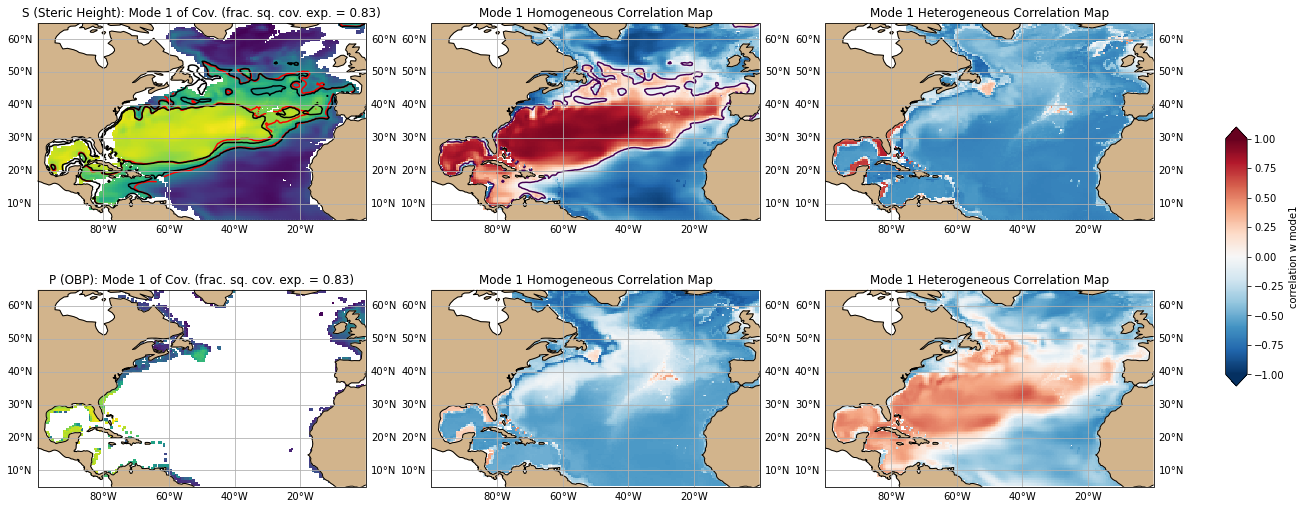

In [53]:
xbs = [lon_w,lon_e]; ybs = [lat_s,lat_n]
# xbs = [-100,-40]; ybs = [10,50]
crrcmp = plt.get_cmap('RdBu_r'); tgcmp = plt.get_cmap('viridis'); 
f, ax = plt.subplots(2,3,figsize=(20,9), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
###########################################
# --- mode1 pattern ---
ax[0,0].pcolor(new_grid_lon,new_grid_lat,re_map1,transform=ccrs.PlateCarree(), vmin=np.nanmin(re_map1), vmax=np.nanmax(re_map1))
ax[0,0].contour(new_grid_lon,new_grid_lat,re_map1,transform=ccrs.PlateCarree(),levels=[0,np.nanstd(re_map1)],colors='r',linewidth=0.5)
ax[0,0].contour(new_grid_lon,new_grid_lat,sha_eof1,transform=ccrs.PlateCarree(),levels=[0,np.nanstd(sha_eof1)],colors='k',linewidth=0.5)
ax[0,0].set_title('S (Steric Height): Mode 1 of Cov. (frac. sq. cov. exp. = ' + str(np.round(S[0]**2/np.sum(S**2),2)) + ')') # S1
ax[0,0].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax[0,0].coastlines()
gl = ax[0,0].gridlines(draw_labels=True); gl.xlabels_top = False; ax[0,0].set_facecolor('w');
ax[0,0].set_xlim(xbs); ax[0,0].set_ylim(ybs); 
# --- homogeneous correlation map ---
cc = ax[0,1].pcolor(new_grid_lon,new_grid_lat,re_corr1_full,vmin=-1,vmax=1,cmap=crrcmp,transform=ccrs.PlateCarree())
ax[0,1].contour(new_grid_lon,new_grid_lat,re_corr1_full,levels=[0],transform=ccrs.PlateCarree())
ax[0,1].set_title('Mode 1 Homogeneous Correlation Map')    
ax[0,1].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax[0,1].coastlines()
gl = ax[0,1].gridlines(draw_labels=True); gl.xlabels_top = False; ax[0,1].set_facecolor('w');
ax[0,1].set_xlim(xbs); ax[0,1].set_ylim(ybs); # ax[0,1].set_facecolor('#66C066')
# --- heterogeneous correlation map 
cc = ax[0,2].pcolor(new_grid_lon,new_grid_lat,re_corr4_full,vmin=-1,vmax=1,cmap=crrcmp,transform=ccrs.PlateCarree())
ax[0,2].set_title('Mode 1 Heterogeneous Correlation Map')    
ax[0,2].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax[0,2].coastlines()
gl = ax[0,2].gridlines(draw_labels=True); gl.xlabels_top = False; ax[0,2].set_facecolor('w');
ax[0,2].set_xlim(xbs); ax[0,2].set_ylim(ybs); # ax[0,2].set_facecolor('#66C066')
###########################################
# xbs = [-140,10]; ybs = [-10,60]
ax[1,0].pcolor(new_grid_lon,new_grid_lat,re_map3,transform=ccrs.PlateCarree(), vmin=np.nanmin(re_map3), vmax=np.nanmax(re_map3))
ax[1,0].set_title('P (OBP): Mode 1 of Cov. (frac. sq. cov. exp. = ' + str(np.round(S[0]**2/np.sum(S**2),2)) + ')') # S2
ax[1,0].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax[1,0].coastlines()
gl = ax[1,0].gridlines(draw_labels=True); gl.xlabels_top = False; ax[1,0].set_facecolor('w');
ax[1,0].set_xlim(xbs); ax[1,0].set_ylim(ybs);
# --- homogeneous correlation map ---
cc = ax[1,1].pcolor(new_grid_lon,new_grid_lat,re_corr3_full,vmin=-1,vmax=1,cmap=crrcmp,transform=ccrs.PlateCarree())
ax[1,1].set_title('Mode 1 Homogeneous Correlation Map')    
ax[1,1].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax[1,1].coastlines()
gl = ax[1,1].gridlines(draw_labels=True); gl.xlabels_top = False; ax[1,1].set_facecolor('w');
ax[1,1].set_xlim(xbs); ax[1,1].set_ylim(ybs);
# --- heterogeneous correlation map 
cc = ax[1,2].pcolor(new_grid_lon,new_grid_lat,re_corr2_full,vmin=-1,vmax=1,cmap=crrcmp,transform=ccrs.PlateCarree())
ax[1,2].set_title('Mode 1 Heterogeneous Correlation Map')    
ax[1,2].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax[1,2].coastlines()
gl = ax[1,2].gridlines(draw_labels=True); gl.xlabels_top = False; ax[1,2].set_facecolor('w');
ax[1,2].set_xlim(xbs); ax[1,2].set_ylim(ybs);

cbpos = [0.95, 0.3, 0.015, 0.4]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='vertical', extend='both', label='correlation w mode1');
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2023_03_02/corr_coeffs_zoom.jpg', dpi=400)

In [54]:
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2023_03_23/corr_coeffs_weof1_2008_2017.jpg', dpi=400)

In [91]:
shelf_obpa_pos_corr = re_corr4_full.copy()
shelf_obpa_pos_corr[shelf_obpa_pos_corr < 0.5] = np.nan

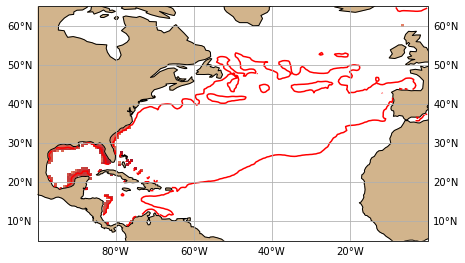

In [94]:
f, ax = plt.subplots(1,1,figsize=(7,5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
ax.contour(new_grid_lon,new_grid_lat,re_corr1_full,levels=[0],transform=ccrs.PlateCarree(),colors='r')
ax.pcolor(new_grid_lon,new_grid_lat,shelf_obpa_pos_corr,vmin=-1,vmax=1,cmap=crrcmp,transform=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False; ax.set_facecolor('w');
ax.set_xlim(xbs); ax.set_ylim(ybs); 

In [101]:
print(ecco_zeta_rho_month_full_w_wosea.time[0].data)
print(ecco_zeta_rho_month_full_w_wosea.time[-1].data)

2008-01-16T12:00:00.000000000
2017-12-16T12:00:00.000000000


In [107]:
# create dataset
filename = ('/Users/jakesteinberg/Documents/NASA_OSTST/analysis/eccov5_sha_obpa_halfdeg_2008_2017_mca.nc')
ds = xr.Dataset(
    data_vars=dict(
        sha_homcor_m1=(["j","i"], re_corr1_full),
        obpa_hetcor_m1=(["j","i"], re_corr4_full),
    ),
    coords=dict(
        j=(["j"], new_grid_lat.data),
        i=(["i"], new_grid_lon.data),
    ),
)
ds.to_netcdf(path=filename)

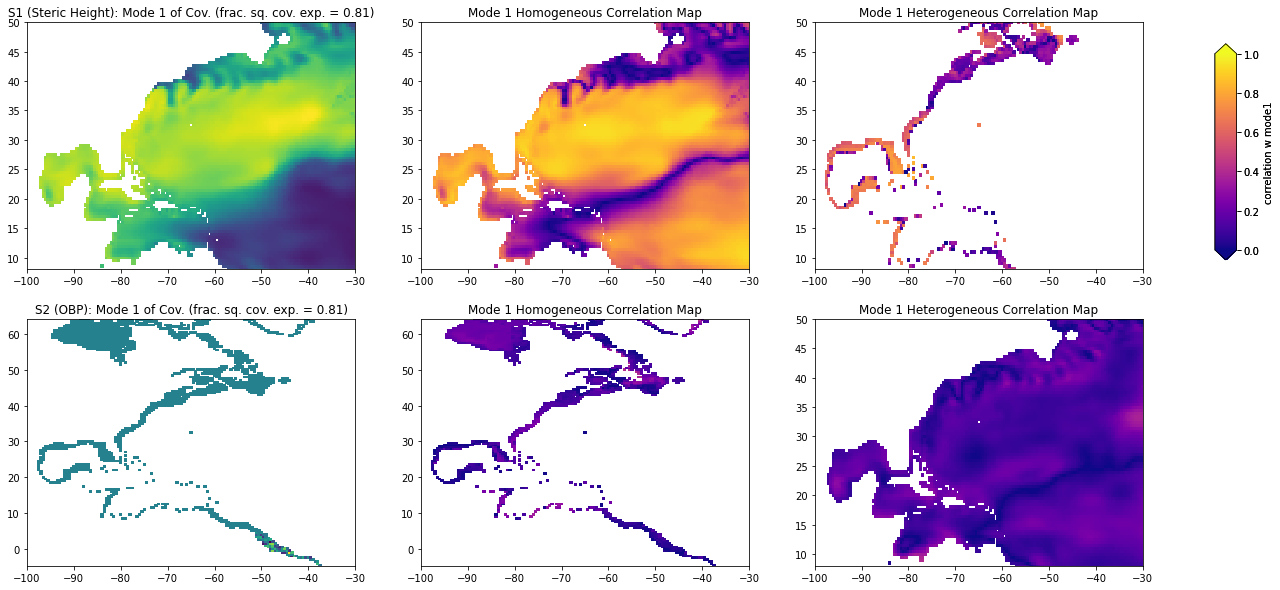

In [67]:
# IF CONSIDERING TIDE GAUGES 
crrcmp = plt.get_cmap('plasma'); tgcmp = plt.get_cmap('viridis'); xbs = [-100,-30]; ybs = [8,50]
f, ax = plt.subplots(2,3,figsize=(20,10))
###########################################
# --- mode1 pattern ---
ax[0,0].pcolor(new_grid_lon,new_grid_lat,re_map1)
ax[0,0].set_title('S1 (Steric Height): Mode 1 of Cov. (frac. sq. cov. exp. = ' + str(np.round(S[0]**2/np.sum(S**2),2)) + ')')
ax[0,0].set_xlim(xbs); ax[0,0].set_ylim(ybs); 
# --- homogeneous correlation map ---
cc = ax[0,1].pcolor(new_grid_lon,new_grid_lat,re_corr1,vmin=0,vmax=1,cmap=crrcmp)
ax[0,1].set_title('Mode 1 Homogeneous Correlation Map')    
ax[0,1].set_xlim(xbs); ax[0,1].set_ylim(ybs); # ax[0,1].set_facecolor('#66C066')
# --- heterogeneous correlation map 
cc = ax[0,2].pcolor(new_grid_lon,new_grid_lat,re_corr4,vmin=0,vmax=1,cmap=crrcmp)
ax[0,2].set_title('Mode 1 Heterogeneous Correlation Map')    
ax[0,2].set_xlim(xbs); ax[0,2].set_ylim(ybs); # ax[0,2].set_facecolor('#66C066')
cbpos = [0.95, 0.55, 0.015, 0.3]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='vertical', extend='both', label='correlation w mode1');
###########################################
# xbs = [-140,10]; ybs = [-10,60]
ax[1,0].pcolor(new_grid_lon,new_grid_lat,re_map3)
ax[1,0].set_title('S2 (OBP): Mode 1 of Cov. (frac. sq. cov. exp. = ' + str(np.round(S[0]**2/np.sum(S**2),2)) + ')')
ax[1,0].set_xlim(xbs); ax[0,0].set_ylim(ybs);
# --- homogeneous correlation map ---
cc = ax[1,1].pcolor(new_grid_lon,new_grid_lat,re_corr3,vmin=0,vmax=1,cmap=crrcmp)
ax[1,1].set_title('Mode 1 Homogeneous Correlation Map')    
ax[1,1].set_xlim(xbs); ax[0,1].set_ylim(ybs);
# --- heterogeneous correlation map 
cc = ax[1,2].pcolor(new_grid_lon,new_grid_lat,re_corr2,vmin=0,vmax=1,cmap=crrcmp)
ax[1,2].set_title('Mode 1 Heterogeneous Correlation Map')    
ax[1,2].set_xlim(xbs); ax[1,2].set_ylim(ybs);
cbpos = [0.95, 0.55, 0.015, 0.3]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='vertical', extend='both', label='correlation w mode1');

In [ ]:
# IF CONSIDERING TIDE GAUGES 
crrcmp = plt.get_cmap('RdBu_r'); tgcmp = plt.get_cmap('viridis'); xbs = [-150,20]; ybs = [-20,70]
f, ax = plt.subplots(2,2,figsize=(13,10))
###########################################
# --- mode1 pattern ---
ax[0,0].pcolor(new_grid_lon,new_grid_lat,re_map1)
ax[0,0].set_title('Steric Height Mode 1 of Covariability (frac. sq. cov. exp. =' + str(np.round(S[0]**2/np.sum(S**2),2)) + ')')
ax[0,0].set_xlim(xbs); ax[0,0].set_ylim(ybs);
# --- correlation map ---
cc = ax[0,1].pcolor(new_grid_lon,new_grid_lat,re_corr1,vmin=-1,vmax=1,cmap=crrcmp)
for i in range(len(V[:,0])):
    ax[0,1].scatter(tide_gauge_anom_month_w.lon[i],tide_gauge_anom_month_w.lat[i],\
                s=50,color=crrcmp((re_corr3[i]+1)/2),edgecolor='k')
ax[0,1].set_title('Mode 1 Correlation Map')    
ax[0,1].set_xlim(xbs); ax[0,1].set_ylim(ybs);
cbpos = [0.95, 0.55, 0.015, 0.3]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='vertical', extend='both', label='correlation w mode1');
###########################################
xbs = [-140,10]; ybs = [-10,60]
# --- mode1 pattern ---
for i in range(len(V[:,0])):
    ax[1,0].scatter(tide_gauge_anom_month_w.lon[i],tide_gauge_anom_month_w.lat[i],\
                s=50,color=tgcmp((V[i,1]-np.nanmin(V[:,1]))/(np.nanmax(V[:,1])-np.nanmin(V[:,1]))),edgecolor='k')
ax[1,0].set_title('Tide Gauge Mode 1 of Covariability (frac. sq. cov. exp. =' + str(np.round(S[0]**2/np.sum(S**2),2)) + ')')
ax[1,0].set_xlim(xbs); ax[1,0].set_ylim(ybs);
# --- correlation map ---
ax[1,1].pcolor(new_grid_lon,new_grid_lat,re_corr2,vmin=-1,vmax=1,cmap=crrcmp)
for i in range(len(V[:,0])):
    ax[1,1].scatter(tide_gauge_anom_month_w.lon[i],tide_gauge_anom_month_w.lat[i],\
                s=50,color=crrcmp((re_corr4[i]+1)/2),edgecolor='k')
ax[1,1].set_title('Mode 1 Correlation Map')   
ax[1,1].set_xlim(xbs); ax[1,1].set_ylim(ybs);
cbpos = [0.95, 0.15, 0.015, 0.3]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='vertical', extend='both', label='correlation w mode1');